# Stochastic Processes: propagation of uncertainties via RunModel

This notebook focuses on the propagation of the generated stochastic proccesses through the Python-based dynamics model defined in the UQpy paper - see **section 3.2.2** in the accompanying paper "UQpy: A general purpose Python package and development environment for uncertainty quantification".

Firstly, the Gaussian and non-Gaussian sample generation code is presented, details of which can be found in 'Translation.ipynb'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 100  # Total time
nt = 256  # Num of Discretized Time
dt = T / nt

F = 1 / T * nt / 2  # Frequency.(Hz)
nw = 128  # Num of Discretized Freq.
dw = F / nw
t_u = 2*np.pi/2/F
if dt>t_u:
    print('Error (aliasing)')

# Generation of Input Data(Stationary)
t = np.linspace(0, T - dt, nt)
w = np.linspace(0, F - dw, nw)

# Compute the power spectral density S(w) at various points frequencies w
S = 130 / 4 * w ** 2 * np.exp(-5 * w)

# Sample 10 realizations of the stochastic process
n_sim = 10

from UQpy.StochasticProcess import SRM
SRM_object = SRM(n_sim, power_spectrum=S, time_duration=[dt], frequency_length=[dw], number_time_intervals=[nt], 
                 number_frequency_intervals=[nw], case='uni', random_state=1234)
samples_g = SRM_object.samples

from UQpy.StochasticProcess import Translation
from UQpy.Distributions import Lognormal

dist_object = Lognormal(0.5, 0, np.exp(0.5))
samples_g = samples_g.flatten()[:, np.newaxis]
Translate_object = Translation(dist_object=dist_object, time_duration=dt, frequency_interval=dw, 
                               number_time_intervals=nt, number_frequency_intervals=nw, power_spectrum_gaussian=S, 
                               samples_gaussian=samples_g)
samples_ng = Translate_object.samples_non_gaussian
samples_ng = samples_ng - np.mean(samples_ng)
samples_ng = samples_ng.reshape([n_sim, nt])
samples_g = samples_g.reshape([n_sim, nt])

The second source of uncertainty arises from the model parameters.

In [2]:
from UQpy.Distributions import Uniform, JointInd
mean_params = [1.0, 2.5, 0.9, 3.]
scale_params = [2. * 0.1 * m for m in mean_params]

samples_k = Uniform(loc=mean_params[0]-scale_params[0]/2, scale=scale_params[0]).rvs(nsamples=n_sim)
samples_r0 = Uniform(loc=mean_params[1]-scale_params[1]/2, scale=scale_params[1]).rvs(nsamples=n_sim)
samples_delta = Uniform(loc=mean_params[2]-scale_params[2]/2, scale=scale_params[2]).rvs(nsamples=n_sim)
samples_n = Uniform(loc=mean_params[3]-scale_params[3]/2, scale=scale_params[3]).rvs(nsamples=n_sim)

Combine the two sources of uncertainty to create a sample set, then propagate using the RunModel 

In [3]:
from UQpy.RunModel import RunModel
dyn_model_prop = RunModel(
    model_script='utils_dynamics.py', model_object_name='sdof_boucwen_prop', ntasks=1, 
    time_vec=t, vec=False, var_names=['k', 'r0', 'delta', 'n', 'input_accel'])

In [4]:
samples = [[k, r0, delta, n, accel] for k, r0, delta, n, accel in 
           zip(samples_k, samples_r0, samples_delta, samples_n, samples_g)]
dyn_model_prop.run(samples=samples, append_samples=False)
qoi_g = np.array(dyn_model_prop.qoi_list)

samples = [[k, r0, delta, n, accel] for k, r0, delta, n, accel in 
           zip(samples_k, samples_r0, samples_delta, samples_n, samples_ng)]
dyn_model_prop.run(samples=samples, append_samples=False)
qoi_ng = np.array(dyn_model_prop.qoi_list)

The plot below depicts the propagated displacement time histories of the dynamics model.

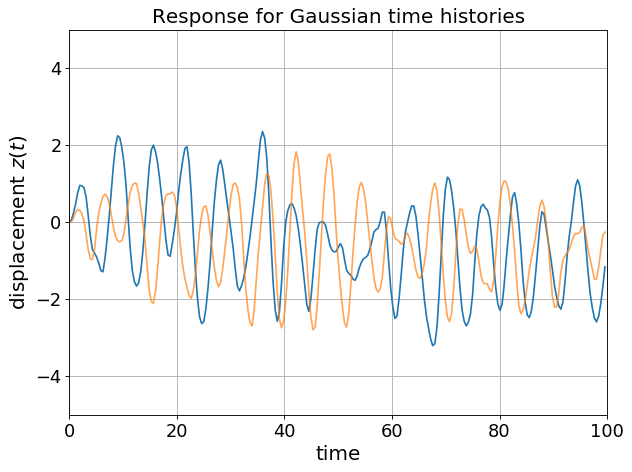

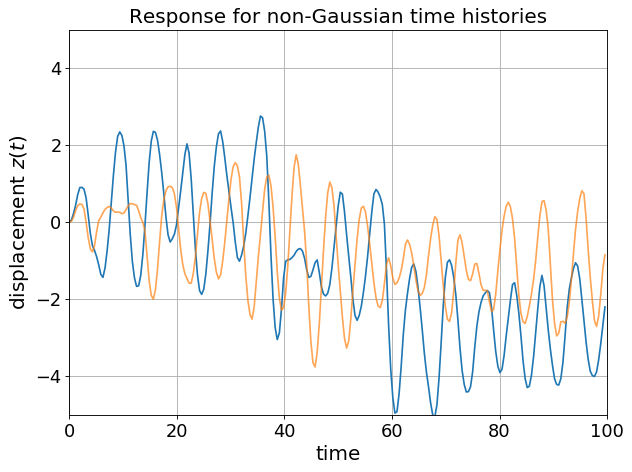

In [5]:
fig1 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for j in range(2):
    plt.plot(t, qoi_g[j], alpha=1.-j*0.3)
plt.xlim(0, 100)
plt.ylim(-5, 5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'time', FontSize=18)
plt.ylabel(r'displacement $z(t)$', FontSize=18)
plt.grid(True, which='both')
plt.title('Response for Gaussian time histories', FontSize=18)
plt.tight_layout()
#plt.savefig('response_gaussian_revision.pdf')
plt.show()

fig2 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for j in range(2):
    plt.plot(t, qoi_ng[j], alpha=1.-j*0.3)
plt.xlim(0, 100)
plt.ylim(-5, 5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'time', FontSize=18)
plt.ylabel(r'displacement $z(t)$', FontSize=18)
plt.grid(True, which='both')
plt.title('Response for non-Gaussian time histories', FontSize=18)
plt.tight_layout()
#plt.savefig('response_lognormal_revision.pdf')
plt.show()